<H1> Escolha do Algoritmo </H1>
Objetivo: Um notebook contendo o processo de escolha do melhor algoritmo;

<p>-> testes com pelo menos 5 algoritmos distintos;
<p>-> testes com pelo menos 10 combinações de parâmetros para cada um dos algoritmos;
<p>-> emprego de técnicas de validação cruzada, considerando a métrica definida para este modelo;
<p>-> exibição de ranking com o desempenho e tempos de execução dos algoritmos avaliados; e decisão automática do melhor algoritmo e respectivos parâmetros.

In [1]:
# Basico
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
import joblib
import pickle
from timeit import default_timer as timer
from shutil import copyfile
warnings.filterwarnings('ignore')


<H1> Referências Gerais vistas nas próximas células </H1>
<H4> https://scikit-learn.org/stable/ </H4>
<H4> https://chrisalbon.com </H4>

In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

<H2>Carga dos Dados</H2>

In [3]:
#CARGA DOS DADOS
data = pd.read_csv(
    "heart-train.csv",             
    na_values=['?']       
)

<H2> Análise Estatística</H2>

In [4]:
data.describe()

,Paciente,Idade,TDP,PAR,CS,ASJ,ECG,FCM,AIE,DST,IST,NVP,Talassemia
count,613.000000,613.000000,613.000000,571.000000,593.000000,553.000000,611.000000,574.000000,574.000000,569.000000,398.000000,207.000000,293.000000
mean,460.464927,53.722675,3.269168,132.360771,199.779089,0.177215,0.608838,136.454704,0.388502,0.870650,1.753769,0.719807,5.163823
std,266.347335,9.472945,0.902599,18.023750,112.727563,0.382196,0.809282,26.347732,0.487835,1.098927,0.606159,0.989628,1.917955
min,2.000000,28.000000,1.000000,80.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000
25%,234.000000,47.000000,3.000000,120.000000,173.000000,0.000000,0.000000,119.250000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,469.000000,54.000000,4.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.500000,2.000000,0.000000,6.000000
75%,691.000000,60.000000,4.000000,142.000000,267.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,1.000000,7.000000
max,919.000000,77.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


count: quanto maior esse número, maior credibilidade todas as estatísticas terão.

mean: é a média e é o valor "esperado" da distribuição. Em média, você esperaria obter esse número.

std: informa o tamanho das oscilações dos dados em relação à média. Especificamente, é o desvio médio quadrático da média ou variância.
Quanto menor é a variância, mais próximos os valores estão da média; mas quanto maior ela é, mais os valores estão distantes da média.


50% também é a mediana e sua diferença em relação à média fornece informações sobre a inclinação da distribuição. Também é outra definição de média que é robusta para discrepantes nos dados.

25% e 75% dão perspectiva sobre a curtose. Além disso, todos os números percentuais são geralmente mais robustos para os valores discrepantes.

min, max, max - min, 75% - 25% são alternativas para perspectivas de quão grande é a variação dos dados em relação à média

In [5]:
#CARGA DOS DADOS
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# data = pd.read_csv("heart-train.csv") 
data = pd.read_csv(
    "heart-train.csv",    # relative python path to subdirectory        
    na_values=['?']       # Take any '.' or '??' values as NA
)

data['Hospital'] = data.Hospital.str.replace('C', '1')
data['Hospital'] = data.Hospital.str.replace('H', '2')
data['Hospital'] = data.Hospital.str.replace('S', '3')
data['Hospital'] = data.Hospital.str.replace('V', '4')
data['Hospital'] = data.Hospital.astype(int)

data['Sexo'] = data.Sexo.str.replace('F', '1')
data['Sexo'] = data.Sexo.str.replace('M', '2')
data['Sexo'] = data.Sexo.astype(int)

data['Diagnóstico'] = data.Diagnóstico.str.replace('A', '0')
data['Diagnóstico'] = data.Diagnóstico.str.replace('P', '1')
data['Diagnóstico'] = data.Diagnóstico.astype(int)

#dummies 
data = pd.get_dummies(data, columns = ['Sexo'])

In [6]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="most_frequent")
data.dtypes
data = data.fillna(data.agg(lambda x: pd.Series.mode(x)[0], axis=0))

# criando a tabela de treinamento e de validação
y = data['Diagnóstico']
X = data.drop(['Diagnóstico'], axis = 1)
X = X.drop(['Paciente'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

#escalar
standardScaler = StandardScaler() #MinMaxScaler()
columns_to_scale = ['TDP', 'PAR','CS', 'ASJ', 'ECG', 'FCM', 'AIE', 'DST', 'IST', 'NVP']
data[columns_to_scale] = standardScaler.fit_transform(data[columns_to_scale])

#para usar depois no REST
scaler_filename = "scaler.save"
joblib.dump(standardScaler, scaler_filename) 
copyfile(scaler_filename, '../../rest/' + scaler_filename)

'../../rest/scaler.save'

In [7]:
print(data)

     Paciente  Hospital  Idade       TDP       PAR        CS       ASJ  \
0         262         1     60 -2.516091  1.046875  0.401791 -0.436224   
1         520         2     54  0.810358 -0.368882  0.264247 -0.436224   
2         264         1     61  0.810358  0.367311 -0.234349 -0.436224   
3         674         3     60 -0.298458 -0.935185 -1.661366 -0.436224   
4         102         1     57  0.810358 -0.198991  0.943370 -0.436224   
..        ...       ...    ...       ...       ...       ...       ...   
608       714         3     69  0.810358 -0.652033 -1.661366 -0.436224   
609       103         1     71 -0.298458 -1.218336  0.616704  2.292401   
610       854         4     55  0.810358  2.292741  0.573721 -0.436224   
611       619         3     47  0.810358 -1.218336 -1.661366 -0.436224   
612       173         1     62  0.810358  0.480572  1.725651 -0.436224   

          ECG       FCM       AIE       DST       IST       NVP  Talassemia  \
0   -0.751011  1.380170 -0.75617

In [8]:
data


,Paciente,Hospital,Idade,TDP,PAR,CS,ASJ,ECG,FCM,AIE,DST,IST,NVP,Talassemia,Diagnóstico,Sexo_1,Sexo_2
0,262,1,60,-2.516091,1.046875,0.401791,-0.436224,-0.751011,1.380170,-0.756171,0.084928,-1.674356,-0.364374,3.0,0,1,0
1,520,2,54,0.810358,-0.368882,0.264247,-0.436224,-0.751011,-0.519920,-0.756171,1.102098,0.318615,-0.364374,7.0,1,0,1
2,264,1,61,0.810358,0.367311,-0.234349,-0.436224,1.724095,-0.403588,1.322452,2.581620,0.318615,1.134695,3.0,1,0,1
3,674,3,60,-0.298458,-0.935185,-1.661366,-0.436224,-0.751011,0.294404,-0.756171,1.471979,-1.674356,-0.364374,7.0,1,0,1
4,102,1,57,0.810358,-0.198991,0.943370,-0.436224,1.724095,0.914841,-0.756171,-0.747303,-1.674356,1.134695,3.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,714,3,69,0.810358,-0.652033,-1.661366,-0.436224,0.486542,-0.597475,-0.756171,-0.747303,0.318615,-0.364374,7.0,1,0,1
609,103,1,71,-0.298458,-1.218336,0.616704,2.292401,1.724095,-0.209701,-0.756171,-0.747303,-1.674356,1.134695,3.0,0,1,0
610,854,4,55,0.810358,2.292741,0.573721,-0.436224,-0.751011,-2.420009,-0.756171,1.102098,0.318615,-0.364374,7.0,1,0,1
611,619,3,47,0.810358,-1.218336,-1.661366,-0.436224,0.486542,0.527068,-0.756171,1.194568,-1.674356,-0.364374,7.0,1,0,1


In [9]:
# criando a tabela de treinamento e de validação
y = data['Diagnóstico']
X = data.drop(['Diagnóstico'], axis = 1)
X = X.drop(['Paciente'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

final_F1 = 0
final_precision = 0
final_recall = 0

best_final = []
models = []

In [10]:
# TODO
# teste k-fold 
#
# df = pd.DataFrame(X)
# y =  pd.DataFrame(y)
# kf = KFold(n_splits = 2, shuffle = True)
# rf_reg = KNeighborsClassifier(91) #RandomForestRegressor()
# scores = []
# for i in range(2):
#     result = next(kf.split(df), None)
#     x_train = df.iloc[result[0]]
#     x_test = df.iloc[result[1]]
#     y_train = y.iloc[result[0]]
#     y_test = y.iloc[result[1]]
#     model = rf_reg.fit(x_train,y_train)
#     predictions = rf_reg.predict(x_test)
#     scores.append(model.score(x_test,y_test))
# print('Scores from each Iteration: ', scores)
# print('Average K-Fold Score :' , np.mean(scores))

<H2> KNN (vizinho mais próximo) </H2>
Ref:
<a href='https://www.monolitonimbus.com.br/classificacao-usando-knn/'  target="_blank"> KNN <a>

Vizinhos:21
Precisão:0.8288288288288288
Recall  :0.8288288288288288
F1 score:0.8288288288288288
Tempo   :8.435005581000041
[['KNN', 'Vizinhos:21', 0.8288288288288288, 0.8288288288288288, 0.8288288288288288, 8.435005581000041]]


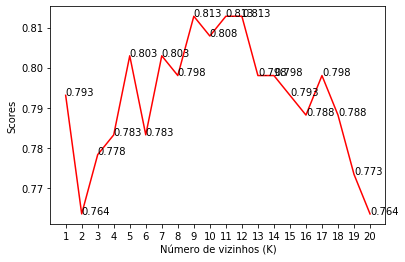

In [11]:
all_neighbors = [7,11,21,31,41,51,61,71,81,111]

scores = []
knn_final_scores=[]
knn_scores = []

neighbors = 0
final_F1 = 0.00001
final_precision = 0.00001
final_recall = 0.00001
parcial_F1 = 0.00001
parcial_precision = 0.00001
parcial_recall = 0.00001

for j in all_neighbors:    
    start_time = timer()
    knn_scores = []
    for k in range(1,j):        
        knn_classifier = KNeighborsClassifier(n_neighbors = k)
        knn_classifier.fit(X_train, y_train)
        y_pred = knn_classifier.predict(X_test)       
        knn_scores.append(knn_classifier.score(X_test, y_test))
        parcial_precision = precision_score(y_test, y_pred)
        parcial_recall = recall_score(y_test, y_pred, average='binary')
        parcial_F1 = float(f1_score(y_test, y_pred, average='binary'))
        if parcial_F1 > final_F1:            
            neighbors = j
            final_precision = parcial_precision
            final_recall = parcial_recall
            final_F1 = parcial_F1
            knn_final_scores = knn_scores            
            final_model = knn_classifier.predict
    end_time = timer()
    total_time = (end_time - start_time)
models.append(final_model)    
print('Vizinhos:'+str(neighbors))    
print('Precisão:'+str(final_precision))
print('Recall  :'+str(final_recall))
print('F1 score:'+str(final_F1))
print('Tempo   :'+str(total_time))

# imprimindo os resultados graficamente
for i in range(1,neighbors):
    arr = round (knn_final_scores[i-1],3)
    plt.text(i, knn_final_scores[i-1], arr)
plt.plot([k for k in range(1, neighbors)], knn_final_scores, color = 'red')
plt.xticks([i for i in range(1, neighbors)])
plt.xlabel('Número de vizinhos (K)')
plt.ylabel('Scores')

best_final.append(['KNN','Vizinhos:'+str(neighbors),final_precision,final_recall,final_F1,total_time])
print (best_final)

<H2> SVC (Support Vector Classifier) </H2>
Ref:
<p>
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html' target="_blank"> Scikiti SVC </a>

<a href='https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/'  target="_blank"> SVC </a>

Kernel:linear
Precisão:0.8333333333333334
Recall  :0.8558558558558559
F1 score:0.8444444444444446
Tempo   :0.030971856999713054
[['KNN', 'Vizinhos:21', 0.8288288288288288, 0.8288288288288288, 0.8288288288288288, 8.435005581000041], ['SVC', 'Kernel:linear', 0.8333333333333334, 0.8558558558558559, 0.8444444444444446, 0.030971856999713054]]


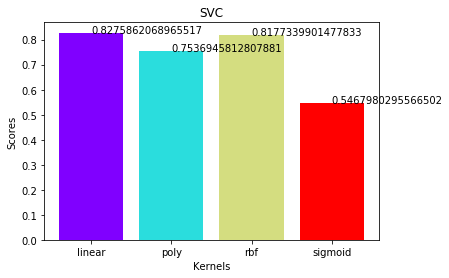

In [12]:
kernels_result = ''
svc_scores = []
final_F1 = 0.0
final_precision = 0.0
final_recall = 0.0
parcial_F1 = 0.01
parcial_precision = 0.0
parcial_recall = 0.0


kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    start_time = timer()
    svc_classifier = SVC(kernel = kernels[i]) #,random_state=0, gamma=10, C=1)
    svc_classifier.fit(X_train, y_train)
    y_pred = svc_classifier.predict(X_test)
    svc_scores.append(svc_classifier.score(X_test, y_test))
    parcial_precision = precision_score(y_test, y_pred)
    parcial_recall = recall_score(y_test, y_pred, average='binary')
    parcial_F1 = float(f1_score(y_test, y_pred, average='binary'))
    if parcial_F1 > final_F1:            
        kernels_result = kernels[i]
        final_precision = parcial_precision
        final_recall = parcial_recall
        final_F1 = parcial_F1
        knn_final_scores = knn_scores    
        final_model = svc_classifier
    end_time = timer()
    total_time = (end_time - start_time)
models.append(final_model)       
print('Kernel:'+str(kernels_result))    
print('Precisão:'+str(final_precision))
print('Recall  :'+str(final_recall))
print('F1 score:'+str(final_F1))
print('Tempo   :'+str(total_time))

colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('SVC') 

best_final.append(['SVC','Kernel:'+str(kernels_result),final_precision,final_recall,final_F1,total_time])
print (best_final)

<H2> Árvore de Decisão </H2>
Ref:
<p>
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html' target="_blank"> Scikiti Decision Tree </a>

<a href='https://medium.com/@randerson112358/python-decision-tree-classifier-example-d73bc3aeca6'  target="_blank"> Decision Tree </a>

0.730593607305936
0.7711864406779662
0.7555555555555554
0.743119266055046
0.7672413793103449
0.7217391304347827
0.7488151658767773
0.780269058295964
0.8
0.8070175438596492
0.7466666666666667
0.7807017543859649
0.7837837837837838
0.8209606986899564
0.7913043478260868
Coluna:14
Precisão:0.7966101694915254
Recall  :0.8468468468468469
F1 score:0.8209606986899564
Tempo   :0.027722546999939368
[['KNN', 'Vizinhos:21', 0.8288288288288288, 0.8288288288288288, 0.8288288288288288, 8.435005581000041], ['SVC', 'Kernel:linear', 0.8333333333333334, 0.8558558558558559, 0.8444444444444446, 0.030971856999713054], ['Decision Tree', 'Coluna:linear', 0.7966101694915254, 0.8468468468468469, 0.8209606986899564, 0.027722546999939368]]


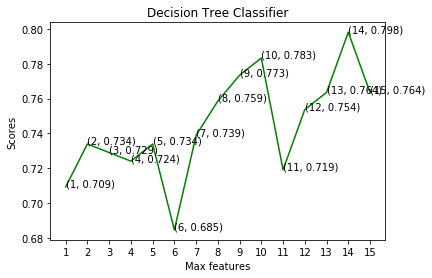

In [13]:
column_result = 0
dt_scores = []

final_F1 = 0.0
final_precision = 0.0
final_recall = 0.0
parcial_F1 = 0.00
parcial_precision = 0.0
parcial_recall = 0.0

for i in range(1, len(X.columns) + 1):
    start_time = timer()
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 10)
    dt_classifier.fit(X_train, y_train)
    y_pred = dt_classifier.predict(X_test)
    dt_scores.append(dt_classifier.score(X_test, y_test))
    parcial_precision = precision_score(y_test, y_pred)
    parcial_recall = recall_score(y_test, y_pred, average='binary')
    parcial_F1 = float(f1_score(y_test, y_pred, average='binary'))    
    print (str(parcial_F1))
    if parcial_F1 > final_F1:         
        column_result = i
        final_precision = parcial_precision
        final_recall = parcial_recall
        final_F1 = parcial_F1
        knn_final_scores = knn_scores     
        final_model = dt_classifier
    end_time = timer()
    total_time = (end_time - start_time)
models.append(final_model)       
print('Coluna:'+str(column_result))    
print('Precisão:'+str(final_precision))
print('Recall  :'+str(final_recall))
print('F1 score:'+str(final_F1))
print('Tempo   :'+str(total_time))

plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')   
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, round(dt_scores[i-1],3)))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier')

best_final.append(['Decision Tree','Coluna:'+str(kernels_result),final_precision,final_recall,final_F1,total_time])
print (best_final)

<H2> Random florest </H2>
Ref:
<p>
<a href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html' target="_blank"> Scikiti Random Forest </a>

<a href='https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/'  target="_blank"> Random Forest </a>


Estimador:10000
Precisão:0.8220338983050848
Recall  :0.8738738738738738
F1 score:0.8471615720524017
Tempo   :43.35841562299993
[['KNN', 'Vizinhos:21', 0.8288288288288288, 0.8288288288288288, 0.8288288288288288, 8.435005581000041], ['SVC', 'Kernel:linear', 0.8333333333333334, 0.8558558558558559, 0.8444444444444446, 0.030971856999713054], ['Decision Tree', 'Coluna:linear', 0.7966101694915254, 0.8468468468468469, 0.8209606986899564, 0.027722546999939368], ['Random Forest', 'Estimador:10000', 0.8220338983050848, 0.8738738738738738, 0.8471615720524017, 43.35841562299993]]


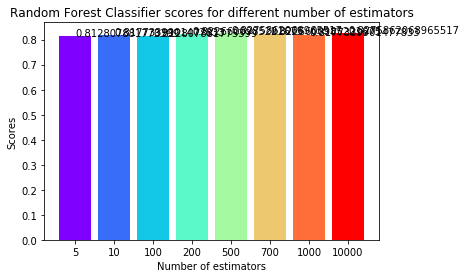

In [14]:
estimator_result = 0
rf_scores = []
estimators = [5, 10, 100, 200, 500, 700, 1000,10000]

final_F1 = 0.0
final_precision = 0.0
final_recall = 0.0
parcial_F1 = 0.00
parcial_precision = 0.0
parcial_recall = 0.0

for i in estimators:
    start_time = timer()
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    rf_scores.append(rf_classifier.score(X_test, y_test))
    parcial_precision = precision_score(y_test, y_pred)
    parcial_recall = recall_score(y_test, y_pred, average='binary')
    parcial_F1 = float(f1_score(y_test, y_pred, average='binary'))
    if parcial_F1 > final_F1:         
        estimator_result = i
        final_precision = parcial_precision
        final_recall = parcial_recall
        final_F1 = parcial_F1
        knn_final_scores = knn_scores            
        final_model = rf_classifier
    end_time = timer()
    total_time = (end_time - start_time)
models.append(final_model)       
print('Estimador:'+str(estimator_result))    
print('Precisão:'+str(final_precision))
print('Recall  :'+str(final_recall))
print('F1 score:'+str(final_F1))
print('Tempo   :'+str(total_time))

colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], rf_scores[i])
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

best_final.append(['Random Forest','Estimador:'+str(estimator_result),final_precision,final_recall,final_F1,total_time])
print (best_final)

<H2> Gaussian Naive Bayes </H2>
Ref:
<p>
<a href='https://scikit-learn.org/stable/modules/naive_bayes.html#out-of-core-naive-bayes-model-fitting' target="_blank"> Scikiti Naive Bayes </a>

<a href='https://chrisalbon.com/machine_learning/naive_bayes/gaussian_naive_bayes_classifier/'  target="_blank"> Naive Bayes </a>

In [15]:
priors_result = 0
gnb_scores = []
priors = [5, 10, 15, 20, 25, 30, 35,40,5, 10, 15, 20, 25, 30, 35]

final_F1 = 0.0
final_precision = 0.0
final_recall = 0.0
parcial_F1 = 0.00
parcial_precision = 0.0
parcial_recall = 0.0

for i in priors:
    start_time = timer()
    gnb_classifier = GaussianNB() #(priors=priors)
    gnb_classifier.fit(X_train, y_train) 
    y_pred = gnb_classifier.predict(X_test)
    gnb_scores.append(gnb_classifier.score(X_test, y_test))
    parcial_precision = precision_score(y_test, y_pred)
    parcial_recall = recall_score(y_test, y_pred, average='binary')
    parcial_F1 = float(f1_score(y_test, y_pred, average='binary'))
    if parcial_F1 > final_F1:         
        priors_result = i
        final_precision = parcial_precision
        final_recall = parcial_recall
        final_F1 = parcial_F1
        knn_final_scores = knn_scores
        final_model = gnb_classifier
    end_time = timer()
    total_time = (end_time - start_time)
models.append(final_model)       
print('Prior:'+str(priors_result))    
print('Precisão:'+str(final_precision))
print('Recall  :'+str(final_recall))
print('F1 score:'+str(final_F1))
print('Tempo   :'+str(total_time))

# colors = rainbow(np.linspace(0, 1, len(priors)))
# plt.bar([i for i in range(len(priors))], rf_scores, color = colors, width = 0.8)
# for i in range(len(priors)):
#     plt.text(i, rf_scores[i], rf_scores[i])
# plt.xticks(ticks = [i for i in range(len(priors))], labels = [str(priors) for priors in priors])
# plt.xlabel('Number of Priors')
# plt.ylabel('Scores')
# plt.title('Gaussian Naive Bayes')

best_final.append(['Gaussian Naive Bayes','Prior:'+str(estimator_result),final_precision,final_recall,final_F1,total_time])
print (best_final)

Prior:5
Precisão:0.8584905660377359
Recall  :0.8198198198198198
F1 score:0.8387096774193548
Tempo   :0.017711873000735068
[['KNN', 'Vizinhos:21', 0.8288288288288288, 0.8288288288288288, 0.8288288288288288, 8.435005581000041], ['SVC', 'Kernel:linear', 0.8333333333333334, 0.8558558558558559, 0.8444444444444446, 0.030971856999713054], ['Decision Tree', 'Coluna:linear', 0.7966101694915254, 0.8468468468468469, 0.8209606986899564, 0.027722546999939368], ['Random Forest', 'Estimador:10000', 0.8220338983050848, 0.8738738738738738, 0.8471615720524017, 43.35841562299993], ['Gaussian Naive Bayes', 'Prior:10000', 0.8584905660377359, 0.8198198198198198, 0.8387096774193548, 0.017711873000735068]]


<H2> Escolha do Melhor Algoritmo </H2>

In [16]:
dataframeFinal=pd.DataFrame(best_final, columns=['Algoritmo','Descrição','Precisão','Recall','F1 Score','Tempo(s)']) 
dataframeFinal.sort_values('F1 Score')

,Algoritmo,Descrição,Precisão,Recall,F1 Score,Tempo(s)
2,Decision Tree,Coluna:linear,0.796610,0.846847,0.820961,0.027723
0,KNN,Vizinhos:21,0.828829,0.828829,0.828829,8.435006
4,Gaussian Naive Bayes,Prior:10000,0.858491,0.819820,0.838710,0.017712
1,SVC,Kernel:linear,0.833333,0.855856,0.844444,0.030972
3,Random Forest,Estimador:10000,0.822034,0.873874,0.847162,43.358416


<H2> Melhor Algoritmo </H2>

In [17]:
winner = dataframeFinal['F1 Score'].argmax()
print(dataframeFinal.loc[winner,:])

Algoritmo      Random Forest
Descrição    Estimador:10000
Precisão            0.822034
Recall              0.873874
F1 Score            0.847162
Tempo(s)             43.3584
Name: 3, dtype: object


In [18]:
filename = 'model.pkl'
pickle.dump(models[winner], open(filename, 'wb'))

In [19]:
copyfile(filename, '../../rest/' + filename)

'../../rest/model.pkl'

In [20]:
result = models[winner].score(X_test, y_test)
print(result)

0.8275862068965517
